In [1]:
from deepscribe2.datasets import PFADetectionDataModule
from deepscribe2.datasets.dataset import collate_retinanet
from deepscribe2.models.detection.retinanet import RetinaNet
import torch
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F
from deepscribe2.models.postprocessing import combine_results
from deepscribe2.evaluation import compute_cls_metrics, compute_cls_metrics_agged


/local/ecw/venvs/deepscribe_public/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
DETECTOR_ARTIFACT = "artifacts/trained_detector_public_multiclass.ckpt"
DATA_DIR = "data/DeepScribe_Data_2023-02-04_public"

In [3]:
detector = RetinaNet.load_from_checkpoint(DETECTOR_ARTIFACT, map_location="cuda", nms_thresh=0.2, score_thresh=0.1).cuda().eval()

/local/ecw/venvs/deepscribe_public/lib/python3.8/site-packages/torchvision/models/detection/backbone_utils.py:160: UserWarning: Changing trainable_backbone_layers has not effect if neither pretrained nor pretrained_backbone have been set to True, falling back to trainable_backbone_layers=5 so that all layers are trainable
  warnings.warn(


In [4]:
pfa_data_module_full = PFADetectionDataModule(
    DATA_DIR,
    autocrop=True, # this will trim images using the provided boxes.
    batch_size=8,
    train_xforms=[], # don't need to bother with these
    localization_only=False,
    start_from_one=True, # need to increment for use with detector!  
)

# This will handle preprocessing/splitting the data. 
# random seed is fixed. 
pfa_data_module_full.prepare_data()

Autocrop directory found. Skipping.
Split files already exist, skipping.


In [5]:
pfa_data_module_full.setup(stage="test")
dataset = pfa_data_module_full.test_dataset

In [6]:
idx = 1
test_img, test_targets = collate_retinanet([dataset[idx]])

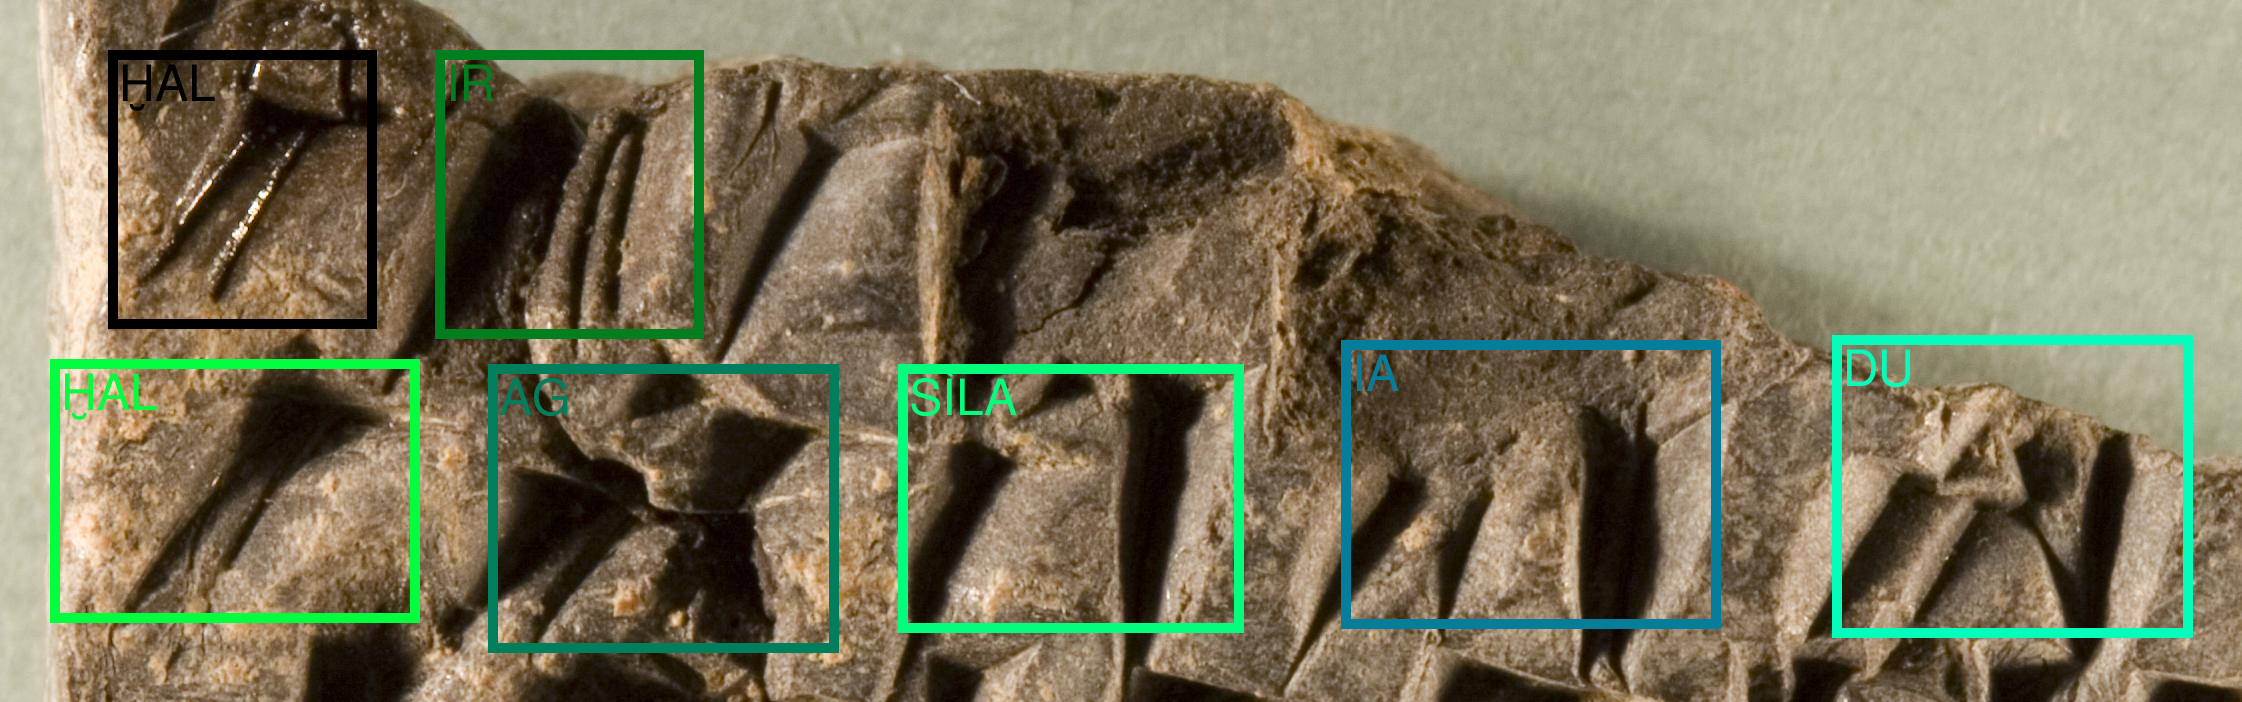

In [7]:
# ground truth boxes from test data
# draw sign classes
# need to decrement b/c of background class!!
gt_signs = [pfa_data_module_full.class_labels[ind - 1] for ind in test_targets[0]["labels"].tolist()]

rescaled_image = (test_img[0]*255).to(torch.uint8)
F.to_pil_image(draw_bounding_boxes(rescaled_image,
                                   test_targets[0]["boxes"],
                                   width=10,
                                   labels=gt_signs,
                                   font="/content/fonts/FreeSans.ttf",
                                  font_size=50))

In [9]:
# run inference!
with torch.no_grad():
    preds = detector([img.cuda() for img in test_img])

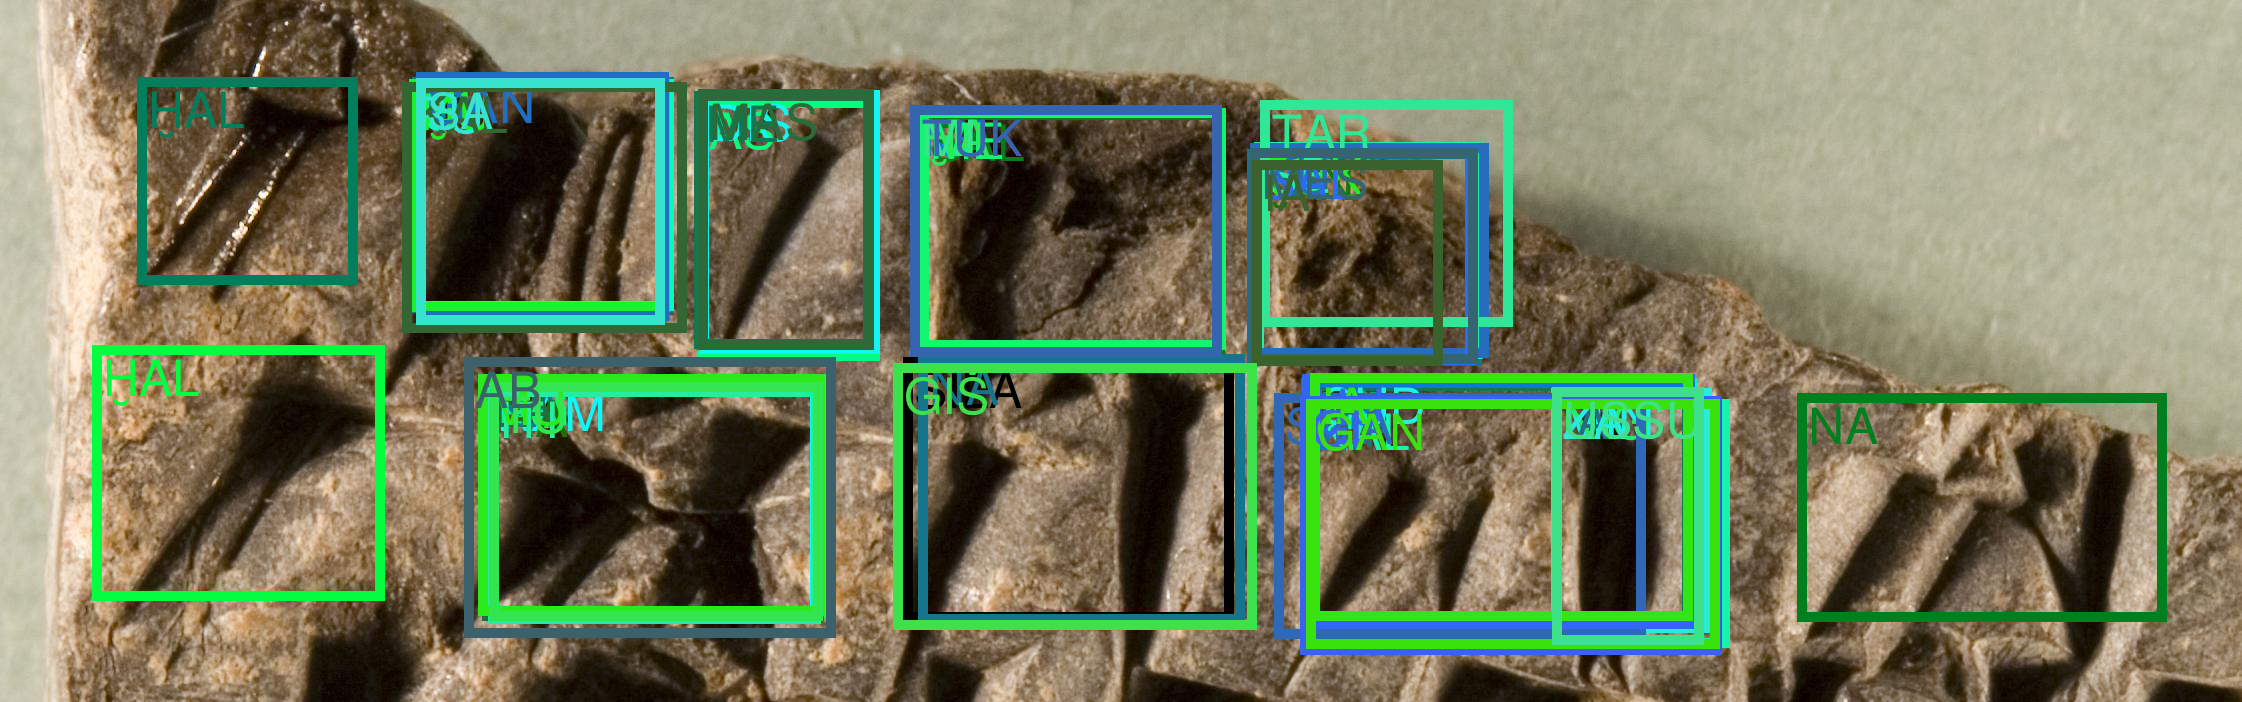

In [10]:
pred_labels = [pfa_data_module_full.class_labels[ind - 1] for ind in preds[0]["labels"].tolist()]
# rendering with end-to-end predictions!
F.to_pil_image(draw_bounding_boxes(rescaled_image,
                                   preds[0]["boxes"],
                                   width=10,
                                   labels=pred_labels,
                                   font="/content/fonts/FreeSans.ttf",
                                  font_size=50))

In [11]:
combined = combine_results(preds[0])

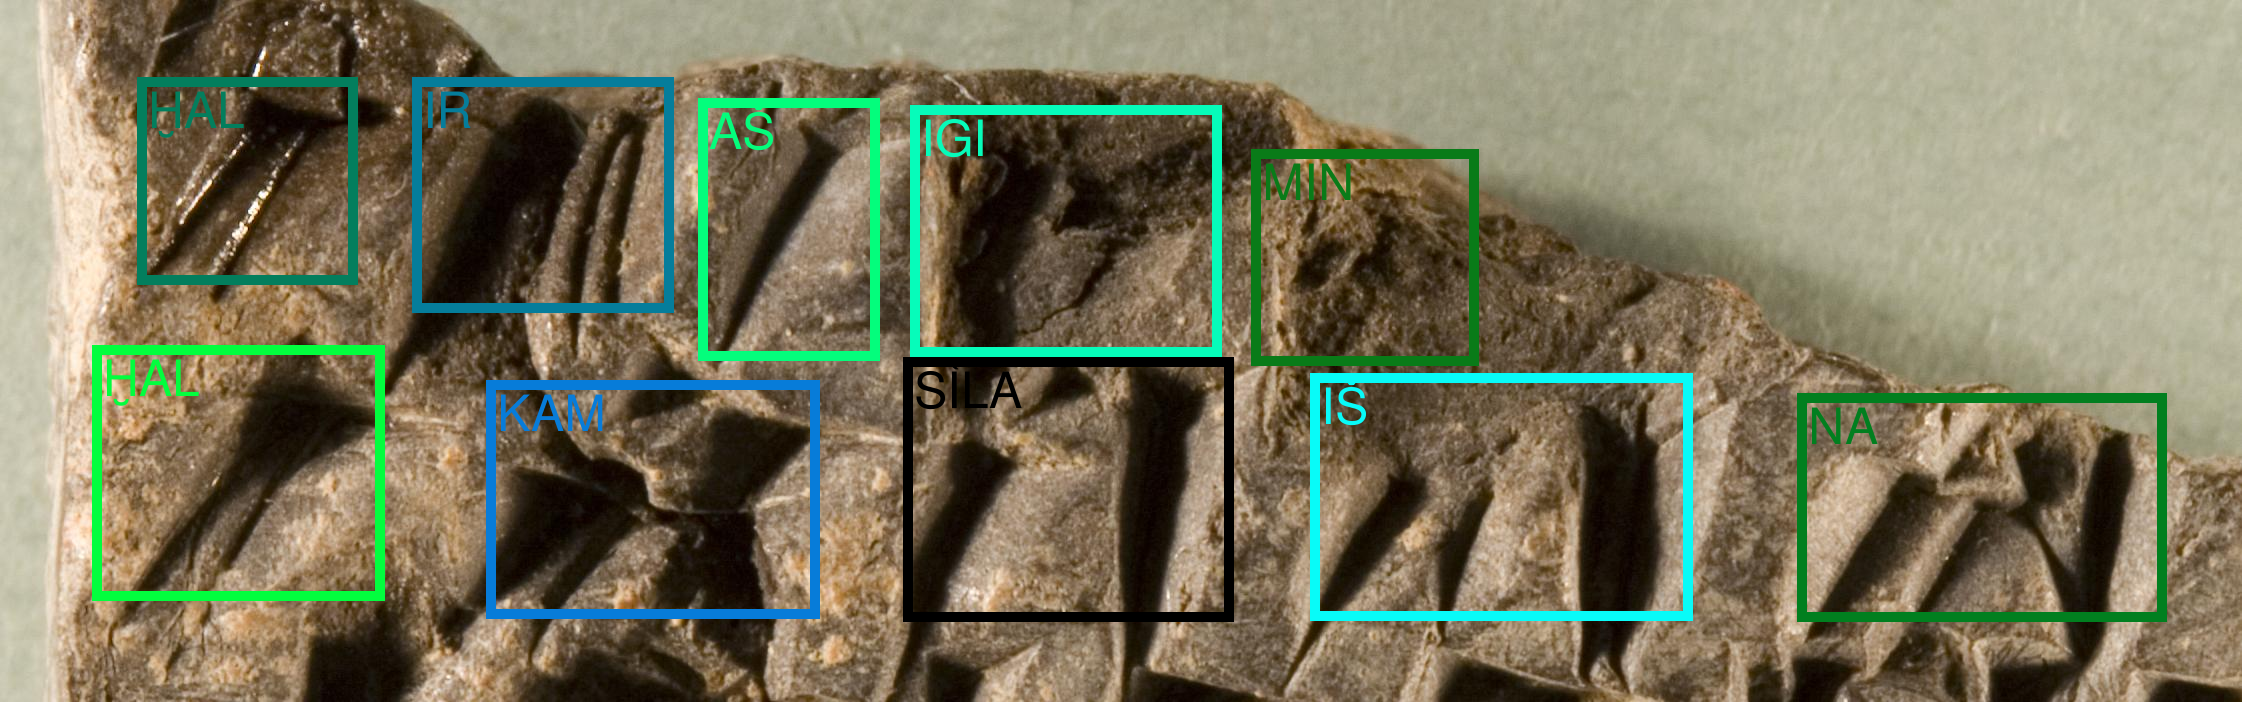

In [12]:
pred_labels = [pfa_data_module_full.class_labels[ind - 1] for ind in combined["labels"].tolist()]
# rendering with end-to-end predictions!
F.to_pil_image(draw_bounding_boxes(rescaled_image,
                                   combined["boxes"],
                                   width=10,
                                   labels=pred_labels,
                                   font="/content/fonts/FreeSans.ttf",
                                  font_size=50))

In [14]:
len(labels_all)

489

In [16]:
compute_cls_metrics_agged(labels_all, preds_all, iou_thresh=0.4)

{'fpr': 0.141014074341393,
 'top1_acc': 0.578130638758571,
 'top5_acc': 0.7270840851678094}